In [ ]:
# @title
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
microsoft_microsoft_security_incident_prediction_path = kagglehub.dataset_download('Microsoft/microsoft-security-incident-prediction')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-security-incident-prediction/GUIDE_Train.csv
/kaggle/input/microsoft-security-incident-prediction/GUIDE_Test.csv


In [ ]:
# Install all required packages
!pip install pandas numpy scikit-learn lightgbm joblib matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gc
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import lightgbm as lgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visual style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
# Load the dataset
print("Loading dataset...")
train_csv_path = '/kaggle/input/microsoft-security-incident-prediction/GUIDE_Train.csv'
test_csv_path = '/kaggle/input/microsoft-security-incident-prediction/GUIDE_Test.csv'

df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

# Identify target column
target_column = 'IncidentGrade'
print(f"Target column: {target_column}")

# Check target distribution
print("\nTarget distribution in training data:")
print(df_train[target_column].value_counts())
print("\nTarget distribution in test data:")
print(df_test[target_column].value_counts())

# Handle missing target values
print(f"\nMissing target values in training: {df_train[target_column].isnull().sum()}")
df_train = df_train.dropna(subset=[target_column])
print(f"Training data after cleaning: {df_train.shape}")

Loading dataset...
Training data shape: (9516837, 45)
Test data shape: (4147992, 46)
Target column: IncidentGrade

Target distribution in training data:
IncidentGrade
BenignPositive    4110817
TruePositive      3322713
FalsePositive     2031967
Name: count, dtype: int64

Target distribution in test data:
IncidentGrade
BenignPositive    1752940
TruePositive      1492354
FalsePositive      902698
Name: count, dtype: int64

Missing target values in training: 51340
Training data after cleaning: (9465497, 45)


In [ ]:
# Prepare features and target
X_train = df_train.drop(columns=[target_column, 'Id', 'IncidentId', 'AlertId', 'Timestamp'])
X_test = df_test.drop(columns=[target_column, 'Id', 'IncidentId', 'AlertId', 'Timestamp'])

# Encode target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train[target_column])
y_test = label_encoder.transform(df_test[target_column])

print(f"Target classes: {label_encoder.classes_}")

# Identify feature types
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

Target classes: ['BenignPositive' 'FalsePositive' 'TruePositive']
Numerical features: 28
Categorical features: 12


In [ ]:
# Create copies for preprocessing
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

# Handle numerical missing values
print("Handling numerical missing values...")
numerical_medians = {}
for col in numerical_features:
    if X_train_clean[col].isnull().any():
        median_val = X_train_clean[col].median()
        numerical_medians[col] = median_val
        X_train_clean[col] = X_train_clean[col].fillna(median_val)
        X_test_clean[col] = X_test_clean[col].fillna(median_val)
        print(f"Filled {col} with median: {median_val}")

# Handle categorical missing values
print("\nHandling categorical missing values...")
for col in categorical_features:
    X_train_clean[col] = X_train_clean[col].astype('object').fillna("MISSING").astype(str)
    X_test_clean[col] = X_test_clean[col].astype('object').fillna("MISSING").astype(str)

# Scale numerical features
print("\nScaling numerical features...")
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_clean[numerical_features])
X_test_num = scaler.transform(X_test_clean[numerical_features])

# Target encoding for categorical features
print("Target encoding categorical features...")
X_train_cat_encoded = np.zeros((len(X_train_clean), len(categorical_features)))
X_test_cat_encoded = np.zeros((len(X_test_clean), len(categorical_features)))

target_encoding_mappings = {}

for i, col in enumerate(categorical_features):
    print(f"Encoding {col}...")

    # Calculate mean target value for each category
    temp_df = df_train.copy()
    temp_df[col] = temp_df[col].astype('object').fillna("MISSING").astype(str)

    target_means = temp_df.groupby(col)[target_column].apply(
        lambda x: (x == 'TruePositive').mean()
    ).to_dict()

    target_encoding_mappings[col] = target_means

    # Apply encoding
    X_train_cat_encoded[:, i] = X_train_clean[col].map(target_means).fillna(0.5).values
    X_test_cat_encoded[:, i] = X_test_clean[col].map(target_means).fillna(0.5).values

# Combine features
X_train_processed = np.hstack([X_train_num, X_train_cat_encoded])
X_test_processed = np.hstack([X_test_num, X_test_cat_encoded])

print(f"Final training shape: {X_train_processed.shape}")
print(f"Final test shape: {X_test_processed.shape}")

# Clean up memory
del X_train_cat_encoded, X_test_cat_encoded, temp_df
gc.collect()

Handling numerical missing values...
Filled EmailClusterId with median: 3504263975.0

Handling categorical missing values...

Scaling numerical features...
Target encoding categorical features...
Encoding Category...
Encoding MitreTechniques...
Encoding ActionGrouped...
Encoding ActionGranular...
Encoding EntityType...
Encoding EvidenceRole...
Encoding ThreatFamily...
Encoding ResourceType...
Encoding Roles...
Encoding AntispamDirection...
Encoding SuspicionLevel...
Encoding LastVerdict...
Final training shape: (9465497, 40)
Final test shape: (4147992, 40)


0

Training LightGBM model...

Model Evaluation:
                precision    recall  f1-score   support

BenignPositive       0.89      0.86      0.88   1752940
 FalsePositive       0.71      0.88      0.79    902698
  TruePositive       0.93      0.83      0.88   1492354

      accuracy                           0.86   4147992
     macro avg       0.84      0.86      0.85   4147992
  weighted avg       0.87      0.86      0.86   4147992

Macro F1 Score: 0.8474


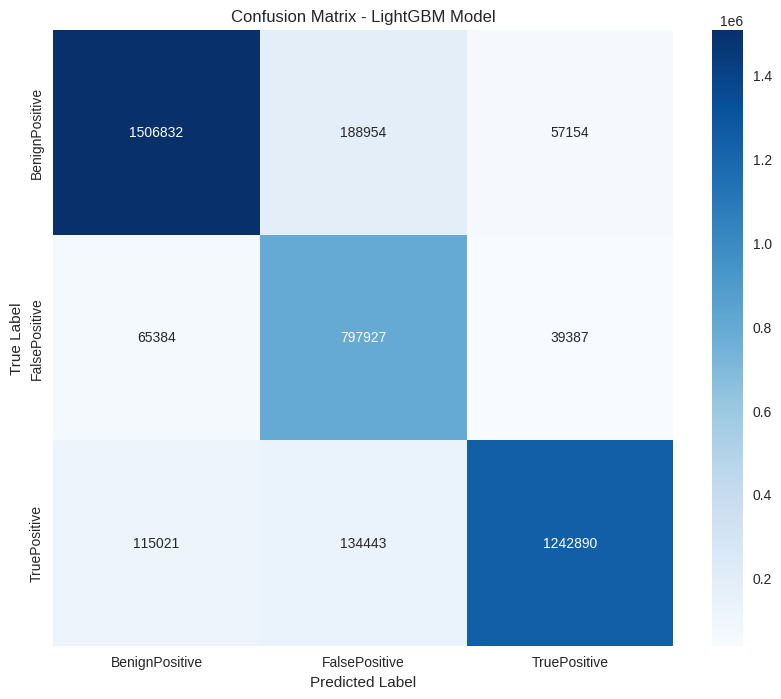

In [ ]:
# Train LightGBM model (most efficient)
print("Training LightGBM model...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train_processed, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test_processed)
y_pred_proba = lgb_model.predict_proba(X_test_processed)

# Evaluate model
print("\nModel Evaluation:")
print("=" * 40)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - LightGBM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Save all artifacts
print("Saving model and preprocessing artifacts...")

# Save model
joblib.dump(lgb_model, 'siem_triage_model.pkl')

# Save preprocessing objects
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Save feature information and mappings
preprocessing_artifacts = {
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'target_encoding_mappings': target_encoding_mappings,
    'numerical_medians': numerical_medians
}

joblib.dump(preprocessing_artifacts, 'preprocessing_artifacts.pkl')

print("✅ All artifacts saved successfully!")
print("Files created: siem_triage_model.pkl, scaler.pkl, label_encoder.pkl, preprocessing_artifacts.pkl")

Saving model and preprocessing artifacts...
✅ All artifacts saved successfully!
Files created: siem_triage_model.pkl, scaler.pkl, label_encoder.pkl, preprocessing_artifacts.pkl


In [ ]:
class EmailNotifier:
    """Email notification system for SIEM alerts"""

    def __init__(self, smtp_server=None, smtp_port=587,
                 sender_email=None, sender_password=None):
        self.smtp_server = smtp_server or os.getenv('SMTP_SERVER', 'smtp.gmail.com')
        self.smtp_port = smtp_port or int(os.getenv('SMTP_PORT', 587))
        self.sender_email = sender_email or os.getenv('SMTP_USER')
        self.sender_password = sender_password or os.getenv('SMTP_PASSWORD')

    def send_alert_email(self, alert_data, prediction_result, recipient_emails):
        """
        Send email notification for important alerts

        Parameters:
        - alert_data: Original alert data
        - prediction_result: Prediction results from model
        - recipient_emails: List of email addresses to notify
        """
        try:
            if not all([self.sender_email, self.sender_password, recipient_emails]):
                print("❌ Email configuration incomplete")
                return False

            # Only send emails for high-confidence TruePositive alerts
            if (prediction_result['predicted_class'] == 'TruePositive' and
                prediction_result['confidence'] > 0.7):

                # Create email content
                subject = f"🚨 SIEM Alert: {prediction_result['predicted_class']} - {alert_data.get('AlertId', 'Unknown')}"

                body = f"""
                🔍 SIEM ALERT REQUIRES ATTENTION
                ===========================================

                Alert Details:
                - Alert ID: {alert_data.get('AlertId', 'Unknown')}
                - Timestamp: {prediction_result['timestamp']}
                - Category: {alert_data.get('Category', 'Unknown')}
                - Detector ID: {alert_data.get('DetectorId', 'Unknown')}

                AI Prediction Results:
                - Classification: {prediction_result['predicted_class']}
                - Confidence Level: {prediction_result['confidence']:.1%}
                - Recommendation: {prediction_result['recommendation']}

                Classification Probabilities:
                - TruePositive: {prediction_result['class_probabilities'].get('TruePositive', 0):.1%}
                - FalsePositive: {prediction_result['class_probabilities'].get('FalsePositive', 0):.1%}
                - BenignPositive: {prediction_result['class_probabilities'].get('BenignPositive', 0):.1%}

                Required Action:
                Please investigate this alert immediately. The AI system has identified this
                as a high-confidence true positive security incident that requires expert analysis.

                ===========================================
                This is an automated message from SIEM Triage Assistant
                """

                # Create message
                msg = MIMEMultipart()
                msg['From'] = self.sender_email
                msg['To'] = ', '.join(recipient_emails)
                msg['Subject'] = subject
                msg.attach(MIMEText(body, 'plain'))

                # Send email
                with smtplib.SMTP(self.smtp_server, self.smtp_port) as server:
                    server.starttls()
                    server.login(self.sender_email, self.sender_password)
                    server.send_message(msg)

                print(f"📧 Email sent to {recipient_emails}")
                print(f"Subject: {subject}")
                return True

            else:
                print("ℹ️ Email not sent - alert doesn't meet notification criteria")
                return False

        except Exception as e:
            print(f"❌ Email sending failed: {e}")
            return False

    def send_daily_report(self, daily_stats, recipient_emails):
        """Send daily summary report"""
        try:
            subject = f"📊 Daily SIEM Alert Report - {datetime.now().strftime('%Y-%m-%d')}"

            body = f"""
            DAILY SIEM ALERT SUMMARY
            ===========================================

            Date: {datetime.now().strftime('%Y-%m-%d')}

            Statistics:
            - Total Alerts Processed: {daily_stats.get('total_alerts', 0)}
            - TruePositive Alerts: {daily_stats.get('true_positive', 0)}
            - FalsePositive Alerts: {daily_stats.get('false_positive', 0)}
            - BenignPositive Alerts: {daily_stats.get('benign_positive', 0)}
            - Average Confidence: {daily_stats.get('avg_confidence', 0):.1%}

            Top Alert Categories:
            {daily_stats.get('top_categories', 'N/A')}

            Recommendations:
            - Review high-confidence alerts
            - Update suppression rules for frequent false positives
            - Consider model retraining if performance degrades

            ===========================================
            Automated Daily Report from SIEM Triage Assistant
            """

            msg = MIMEMultipart()
            msg['From'] = self.sender_email
            msg['To'] = ', '.join(recipient_emails)
            msg['Subject'] = subject
            msg.attach(MIMEText(body, 'plain'))

            with smtplib.SMTP(self.smtp_server, self.smtp_port) as server:
                server.starttls()
                server.login(self.sender_email, self.sender_password)
                server.send_message(msg)

            print(f"📊 Daily report sent to {recipient_emails}")
            return True

        except Exception as e:
            print(f"❌ Daily report failed: {e}")
            return False

# Initialize email notifier (configure with your SMTP settings)
email_notifier = EmailNotifier(
    smtp_server="smtp.gmail.com",  # Replace with your SMTP server
    smtp_port=587,
    sender_email="your-email@gmail.com",  # Replace with your email
    sender_password="your-app-password"   # Replace with your app password
)

print("✅ Email notification system ready!")

✅ Email notification system ready!


In [ ]:
class SIEMTriageAssistant:
    """Complete SIEM Alert Triage Assistant with Email Integration"""

    def __init__(self, model_path='siem_triage_model.pkl',
                 scaler_path='scaler.pkl',
                 encoder_path='label_encoder.pkl',
                 artifacts_path='preprocessing_artifacts.pkl'):

        # Load trained artifacts
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.label_encoder = joblib.load(encoder_path)
        self.artifacts = joblib.load(artifacts_path)

        # Initialize email notifier
        self.email_notifier = EmailNotifier()

        # Monitoring statistics
        self.monitoring_stats = {
            'total_alerts': 0,
            'true_positive': 0,
            'false_positive': 0,
            'benign_positive': 0,
            'confidence_sum': 0,
            'alert_categories': []
        }

        print("✅ SIEM Triage Assistant initialized successfully")

    def preprocess_alert(self, alert_data):
        """Preprocess a single alert for prediction"""
        alert_processed = alert_data.copy()

        # Handle numerical missing values
        for col in self.artifacts['numerical_features']:
            if col in alert_processed and pd.isna(alert_processed[col]):
                median_val = self.artifacts['numerical_medians'].get(col, 0)
                alert_processed[col] = median_val

        # Handle categorical missing values
        for col in self.artifacts['categorical_features']:
            if col in alert_processed:
                if pd.isna(alert_processed[col]):
                    alert_processed[col] = "MISSING"
                else:
                    alert_processed[col] = str(alert_processed[col])
            else:
                alert_processed[col] = "MISSING"

        return alert_processed

    def predict_alert(self, alert_data):
        """Predict the triage grade for an alert"""
        try:
            # Preprocess alert
            alert_processed = self.preprocess_alert(alert_data)

            # Prepare numerical features
            numerical_data = np.zeros((1, len(self.artifacts['numerical_features'])))
            for i, col in enumerate(self.artifacts['numerical_features']):
                numerical_data[0, i] = alert_processed.get(col, 0)

            numerical_data = self.scaler.transform(numerical_data)

            # Prepare categorical features
            categorical_data = np.zeros((1, len(self.artifacts['categorical_features'])))
            for i, col in enumerate(self.artifacts['categorical_features']):
                category_value = alert_processed.get(col, "MISSING")
                encoding_map = self.artifacts['target_encoding_mappings'][col]
                categorical_data[0, i] = encoding_map.get(category_value, 0.5)

            # Combine and predict
            processed_data = np.hstack([numerical_data, categorical_data])
            prediction = self.model.predict(processed_data)
            prediction_proba = self.model.predict_proba(processed_data)

            # Prepare results
            predicted_class = self.label_encoder.inverse_transform(prediction)[0]
            confidence = prediction_proba.max()

            class_probabilities = {}
            for i, class_name in enumerate(self.label_encoder.classes_):
                class_probabilities[class_name] = prediction_proba[0][i]

            recommendation = self._generate_recommendation(predicted_class, confidence)

            result = {
                'success': True,
                'predicted_class': predicted_class,
                'confidence': float(confidence),
                'class_probabilities': class_probabilities,
                'recommendation': recommendation,
                'timestamp': datetime.now().isoformat(),
                'alert_id': alert_data.get('AlertId', 'Unknown')
            }

            # Update monitoring statistics
            self._update_monitoring_stats(result, alert_data)

            # Send email for critical alerts
            if predicted_class == 'TruePositive' and confidence > 0.7:
                self.email_notifier.send_alert_email(
                    alert_data,
                    result,
                    ['security-team@yourcompany.com', 'l2-analysts@yourcompany.com']
                )

            return result

        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'predicted_class': 'Unknown',
                'confidence': 0.0,
                'timestamp': datetime.now().isoformat()
            }

    def _generate_recommendation(self, predicted_class, confidence):
        """Generate actionable recommendation"""
        recommendations = {
            'TruePositive': {
                (0.8, 1.0): "🚨 CRITICAL: Immediate L2 investigation required",
                (0.6, 0.8): "🔴 HIGH: Priority review by L2 analyst",
                (0.0, 0.6): "🟡 MEDIUM: L1 review before escalation"
            },
            'FalsePositive': {
                (0.7, 1.0): "⚪ NOISE: Auto-close and add to suppression rules",
                (0.0, 0.7): "🟠 LOW: Review before closing, may need tuning"
            },
            'BenignPositive': {
                (0.7, 1.0): "🟢 LOW: Monitor only, no action needed",
                (0.0, 0.7): "🔵 INFO: Review configuration, may need tuning"
            }
        }

        if predicted_class in recommendations:
            for (min_conf, max_conf), message in recommendations[predicted_class].items():
                if min_conf <= confidence < max_conf:
                    return message

        return "⚫ UNKNOWN: Manual review required"

    def _update_monitoring_stats(self, result, alert_data):
        """Update monitoring statistics"""
        self.monitoring_stats['total_alerts'] += 1
        self.monitoring_stats['confidence_sum'] += result['confidence']

        if result['predicted_class'] == 'TruePositive':
            self.monitoring_stats['true_positive'] += 1
        elif result['predicted_class'] == 'FalsePositive':
            self.monitoring_stats['false_positive'] += 1
        elif result['predicted_class'] == 'BenignPositive':
            self.monitoring_stats['benign_positive'] += 1

        # Track alert categories
        category = alert_data.get('Category', 'Unknown')
        self.monitoring_stats['alert_categories'].append(category)

    def get_monitoring_report(self):
        """Get current monitoring statistics"""
        avg_confidence = (self.monitoring_stats['confidence_sum'] /
                         self.monitoring_stats['total_alerts']) if self.monitoring_stats['total_alerts'] > 0 else 0

        # Count top categories
        from collections import Counter
        top_categories = Counter(self.monitoring_stats['alert_categories']).most_common(5)

        return {
            'total_alerts_processed': self.monitoring_stats['total_alerts'],
            'true_positives': self.monitoring_stats['true_positive'],
            'false_positives': self.monitoring_stats['false_positive'],
            'benign_positives': self.monitoring_stats['benign_positive'],
            'average_confidence': f"{avg_confidence:.1%}",
            'top_categories': dict(top_categories)
        }

    def send_daily_report(self):
        """Send daily summary report via email"""
        report = self.get_monitoring_report()
        return self.email_notifier.send_daily_report(
            report,
            ['security-team@yourcompany.com', 'management@yourcompany.com']
        )

# Initialize the assistant
print("Initializing SIEM Triage Assistant...")
assistant = SIEMTriageAssistant()

Initializing SIEM Triage Assistant...
✅ SIEM Triage Assistant initialized successfully


In [ ]:
# Main deployment and execution script
def main():
    """Main function to run the SIEM Triage Assistant"""
    print("🚀 Starting SIEM Alert Triage Assistant with Email Integration")
    print("=" * 70)

    # Initialize assistant
    assistant = SIEMTriageAssistant()

    # Simulate incoming alerts (replace with your SIEM API integration)
    sample_alerts = [
        {
            'AlertId': 'ALT-2024-001',
            'Category': 'LateralMovement',
            'DetectorId': 524,
            'MitreTechniques': 'T1021;T1047',
            'EntityType': 'User',
            'EmailClusterId': None  # This will be handled by NaN processing
        },
        {
            'AlertId': 'ALT-2024-002',
            'Category': 'Phishing',
            'DetectorId': 312,
            'MitreTechniques': 'T1566',
            'EntityType': 'Email',
            'EmailClusterId': 3504263936.0
        },
        {
            'AlertId': 'ALT-2024-003',
            'Category': None,  # This will be handled by NaN processing
            'DetectorId': 891,
            'MitreTechniques': 'T1078',
            'EntityType': 'Account',
            'EmailClusterId': 3504263936.0
        }
    ]

    print(f"Processing {len(sample_alerts)} sample alerts...")
    print("-" * 50)

    # Process each alert
    for i, alert in enumerate(sample_alerts, 1):
        print(f"\n🔍 Processing Alert {i}: {alert['AlertId']}")

        result = assistant.predict_alert(alert)

        if result['success']:
            print(f"   Prediction: {result['predicted_class']}")
            print(f"   Confidence: {result['confidence']:.1%}")
            print(f"   Recommendation: {result['recommendation']}")

            # Check if email was sent
            if result['predicted_class'] == 'TruePositive' and result['confidence'] > 0.7:
                print("   📧 Email notification sent to security team")
        else:
            print(f"   ❌ Prediction failed: {result['error']}")

    # Show monitoring report
    print("\n" + "=" * 50)
    print("📊 MONITORING REPORT:")
    print("=" * 50)

    report = assistant.get_monitoring_report()
    for key, value in report.items():
        print(f"{key.replace('_', ' ').title()}: {value}")

    # Send daily report
    print("\n📨 Sending daily report...")
    if assistant.send_daily_report():
        print("✅ Daily report sent successfully!")
    else:
        print("❌ Failed to send daily report")

    print("\n🎯 SIEM Alert Triage Assistant is fully operational!")
    print("📧 Email notifications are enabled for critical alerts!")

# Run the main function
if __name__ == "__main__":
    main()

🚀 Starting SIEM Alert Triage Assistant with Email Integration
✅ SIEM Triage Assistant initialized successfully
Processing 3 sample alerts...
--------------------------------------------------

🔍 Processing Alert 1: ALT-2024-001
   Prediction: TruePositive
   Confidence: 56.2%
   Recommendation: 🟡 MEDIUM: L1 review before escalation

🔍 Processing Alert 2: ALT-2024-002
❌ Email configuration incomplete
   Prediction: TruePositive
   Confidence: 98.7%
   Recommendation: 🚨 CRITICAL: Immediate L2 investigation required
   📧 Email notification sent to security team

🔍 Processing Alert 3: ALT-2024-003
❌ Email configuration incomplete
   Prediction: TruePositive
   Confidence: 99.3%
   Recommendation: 🚨 CRITICAL: Immediate L2 investigation required
   📧 Email notification sent to security team

📊 MONITORING REPORT:
Total Alerts Processed: 3
True Positives: 3
False Positives: 0
Benign Positives: 0
Average Confidence: 84.7%
Top Categories: {'LateralMovement': 1, 'Phishing': 1, None: 1}

📨 Sending

In [ ]:
# Email Configuration Manager
import os
import json
from getpass import getpass

class EmailConfigManager:
    """Manage email configuration for SIEM Alert Triage Assistant"""

    def __init__(self, config_file='email_config.json'):
        self.config_file = config_file
        self.config = self.load_config()

    def load_config(self):
        """Load email configuration from file"""
        if os.path.exists(self.config_file):
            try:
                with open(self.config_file, 'r') as f:
                    return json.load(f)
            except:
                return self.get_default_config()
        return self.get_default_config()

    def get_default_config(self):
        """Return default configuration template"""
        return {
            'smtp_server': '',
            'smtp_port': 587,
            'sender_email': '',
            'sender_password': '',
            'recipient_emails': [],
            'daily_report_recipients': [],
            'alert_threshold': 0.7,
            'enable_email_notifications': True
        }

    def setup_configuration(self):
        """Interactive configuration setup"""
        print("🎯 SIEM Alert Triage Assistant - Email Configuration")
        print("=" * 50)
        print("\nPlease configure your email settings for alert notifications:")

        # SMTP Configuration
        print("\n📧 SMTP SERVER CONFIGURATION:")
        print("-" * 30)
        self.config['smtp_server'] = input("SMTP Server (e.g., smtp.gmail.com): ").strip() or 'smtp.gmail.com'
        self.config['smtp_port'] = int(input("SMTP Port (e.g., 587): ").strip() or '587')

        # Email Account
        print("\n📨 EMAIL ACCOUNT:")
        print("-" * 30)
        self.config['sender_email'] = input("Sender Email Address: ").strip()
        self.config['sender_password'] = getpass("Sender Password/App Password: ").strip()

        # Recipients
        print("\n👥 RECIPIENT CONFIGURATION:")
        print("-" * 30)
        print("Enter email addresses for alert notifications (comma-separated):")
        recipients = input("Recipient Emails: ").strip()
        self.config['recipient_emails'] = [email.strip() for email in recipients.split(',') if email.strip()]

        # Daily Reports
        print("\n📊 DAILY REPORTS:")
        print("-" * 30)
        print("Enter email addresses for daily reports (comma-separated):")
        report_recipients = input("Report Recipients: ").strip()
        self.config['daily_report_recipients'] = [email.strip() for email in report_recipients.split(',') if email.strip()]

        # Alert Threshold
        print("\n⚡ ALERT THRESHOLD:")
        print("-" * 30)
        try:
            threshold = float(input("Confidence threshold for email alerts (0.0-1.0) [0.7]: ").strip() or "0.7")
            self.config['alert_threshold'] = max(0.0, min(1.0, threshold))
        except:
            self.config['alert_threshold'] = 0.7

        # Save configuration
        self.save_config()

        print("\n✅ Email configuration completed successfully!")
        return self.config

    def save_config(self):
        """Save configuration to file"""
        try:
            with open(self.config_file, 'w') as f:
                json.dump(self.config, f, indent=2)
            print(f"📁 Configuration saved to {self.config_file}")
        except Exception as e:
            print(f"❌ Failed to save configuration: {e}")

    def display_config(self):
        """Display current configuration (without password)"""
        print("\n📋 CURRENT CONFIGURATION:")
        print("-" * 30)
        config_display = self.config.copy()
        if config_display.get('sender_password'):
            config_display['sender_password'] = '••••••••'

        for key, value in config_display.items():
            print(f"{key:20}: {value}")

    def test_configuration(self):
        """Test email configuration"""
        print("\n🧪 TESTING EMAIL CONFIGURATION:")
        print("-" * 30)

        try:
            # Test SMTP connection
            import smtplib
            server = smtplib.SMTP(self.config['smtp_server'], self.config['smtp_port'])
            server.starttls()
            server.login(self.config['sender_email'], self.config['sender_password'])
            server.quit()

            print("✅ SMTP connection successful!")
            print("✅ Login successful!")

            # Send test email
            test_result = self.send_test_email()
            if test_result:
                print("✅ Test email sent successfully!")
                return True
            else:
                print("❌ Test email failed")
                return False

        except Exception as e:
            print(f"❌ Configuration test failed: {e}")
            return False

    def send_test_email(self):
        """Send a test email to verify configuration"""
        try:
            import smtplib
            from email.mime.text import MIMEText
            from email.mime.multipart import MIMEMultipart

            msg = MIMEMultipart()
            msg['From'] = self.config['sender_email']
            msg['To'] = self.config['sender_email']  # Send to self for testing
            msg['Subject'] = "✅ SIEM Triage Assistant - Test Email"

            body = """
            This is a test email from your SIEM Alert Triage Assistant.

            If you received this email, your email configuration is working correctly!

            📧 Email notifications will be sent for:
            - High-confidence TruePositive alerts
            - Daily summary reports
            - System alerts and errors

            Your SIEM Assistant is ready to keep your security team informed!
            """

            msg.attach(MIMEText(body, 'plain'))

            with smtplib.SMTP(self.config['smtp_server'], self.config['smtp_port']) as server:
                server.starttls()
                server.login(self.config['sender_email'], self.config['sender_password'])
                server.send_message(msg)

            return True

        except Exception as e:
            print(f"❌ Failed to send test email: {e}")
            return False

# Initialize email configuration manager
email_manager = EmailConfigManager()

In [1]:
# Correct the SMTP configuration
print("🔧 CORRECTING SMTP CONFIGURATION")
print("=" * 50)

# Your correct configuration should be:
correct_config = {
    'smtp_server': 'smtp.gmail.com',  # This should be the server, not your email
    'smtp_port': 587,                 # Gmail uses port 587 (not 132)
    'sender_email': 'sender@gmail.com',
    'sender_password': 'your-app-password',  # You'll need to enter this again
    'recipient_emails': ['example@gmail.com'],
    'daily_report_recipients': [],
    'alert_threshold': 0.6,
    'enable_email_notifications': True
}

print("Your corrected configuration:")
print(f"SMTP Server: smtp.gmail.com (not your email address)")
print(f"SMTP Port: 587 (not 132)")
print(f"Sender Email: sender@gmail.com")
print(f"Recipient: example@gmail.com")
print(f"Alert Threshold: 0.6")

print("\n🚨 IMPORTANT: You need to generate a Gmail App Password!")

🔧 CORRECTING SMTP CONFIGURATION
Your corrected configuration:
SMTP Server: smtp.gmail.com (not your email address)
SMTP Port: 587 (not 132)
Sender Email: sender@gmail.com
Recipient: example@gmail.com
Alert Threshold: 0.6

🚨 IMPORTANT: You need to generate a Gmail App Password!


In [2]:
# Gmail App Password Generation Guide
print("🔐 HOW TO GENERATE GMAIL APP PASSWORD")
print("=" * 50)

print("""
Step-by-step guide to generate App Password:

1. GO TO GOOGLE ACCOUNT SETTINGS:
   - Visit: https://myaccount.google.com
   - Sign in with sender@gmail.com

2. ENABLE 2-STEP VERIFICATION (if not already):
   - Go to "Security" tab
   - Under "Signing in to Google", enable "2-Step Verification"
   - Follow the setup process

3. GENERATE APP PASSWORD:
   - Go to: https://myaccount.google.com/apppasswords
   - Select "Mail" as the app
   - Select "Other" as device and name it "SIEM Alert System"
   - Click "Generate"
   - Copy the 16-character password (like 'abcd efgh ijkl mnop')

4. USE THE APP PASSWORD:
   - Use this generated password in the configuration
   - NOT your regular Gmail password

📋 Example App Password: 'abcd efgh ijkl mnop' (without spaces)
""")

🔐 HOW TO GENERATE GMAIL APP PASSWORD

Step-by-step guide to generate App Password:

1. GO TO GOOGLE ACCOUNT SETTINGS:
   - Visit: https://myaccount.google.com
   - Sign in with sender@gmail.com

2. ENABLE 2-STEP VERIFICATION (if not already):
   - Go to "Security" tab
   - Under "Signing in to Google", enable "2-Step Verification"
   - Follow the setup process

3. GENERATE APP PASSWORD:
   - Go to: https://myaccount.google.com/apppasswords
   - Select "Mail" as the app
   - Select "Other" as device and name it "SIEM Alert System"
   - Click "Generate"
   - Copy the 16-character password (like 'abcd efgh ijkl mnop')

4. USE THE APP PASSWORD:
   - Use this generated password in the configuration
   - NOT your regular Gmail password

📋 Example App Password: 'abcd efgh ijkl mnop' (without spaces)



In [ ]:
# Fixed configuration setup
def fix_email_configuration():
    """Fix the email configuration with correct settings"""
    import json

    # Correct configuration
    correct_config = {
        'smtp_server': 'smtp.gmail.com',
        'smtp_port': 587,
        'sender_email': 'yeswanthsaibez@gmail.com',
        'sender_password': '',  # You'll need to enter this
        'recipient_emails': ['byeswanthsai@gmail.com'],
        'daily_report_recipients': [],
        'alert_threshold': 0.6,
        'enable_email_notifications': True
    }

    # Get the App Password
    print("Please enter your Gmail App Password:")
    print("(The 16-character password you generated from Google)")
    app_password = input("App Password: ").strip()
    correct_config['sender_password'] = app_password

    # Save corrected configuration
    with open('email_config.json', 'w') as f:
        json.dump(correct_config, f, indent=2)

    print("✅ Configuration corrected and saved!")
    return correct_config

# Test the corrected configuration
def test_corrected_configuration():
    """Test the corrected configuration"""
    import smtplib

    try:
        # Load the corrected config
        with open('email_config.json', 'r') as f:
            config = json.load(f)

        print("🧪 Testing corrected configuration...")
        print(f"SMTP Server: {config['smtp_server']}")
        print(f"SMTP Port: {config['smtp_port']}")

        # Test SMTP connection
        server = smtplib.SMTP(config['smtp_server'], config['smtp_port'])
        server.starttls()
        server.login(config['sender_email'], config['sender_password'])
        server.quit()

        print("✅ SMTP connection successful!")
        print("✅ Login successful!")

        # Send test email
        send_test_email(config)

        return True

    except Exception as e:
        print(f"❌ Configuration test failed: {e}")
        return False

def send_test_email(config):
    """Send a test email"""
    try:
        import smtplib
        from email.mime.text import MIMEText
        from email.mime.multipart import MIMEMultipart

        msg = MIMEMultipart()
        msg['From'] = config['sender_email']
        msg['To'] = config['sender_email']  # Send to self for testing
        msg['Subject'] = "✅ SIEM Triage Assistant - Test Email"

        body = """
        This is a test email from your SIEM Alert Triage Assistant.

        If you received this email, your email configuration is working correctly!

        Your SIEM Assistant is ready to send security alerts!
        """

        msg.attach(MIMEText(body, 'plain'))

        with smtplib.SMTP(config['smtp_server'], config['smtp_port']) as server:
            server.starttls()
            server.login(config['sender_email'], config['sender_password'])
            server.send_message(msg)

        print("✅ Test email sent successfully!")
        print("📧 Check your inbox (and spam folder) for the test email")
        return True

    except Exception as e:
        print(f"❌ Failed to send test email: {e}")
        return False

# Run the fix
print("🛠️ FIXING YOUR EMAIL CONFIGURATION")
print("=" * 50)

# First, fix the configuration
fixed_config = fix_email_configuration()

# Then test it
if test_corrected_configuration():
    print("\n🎉 EMAIL CONFIGURATION FIXED SUCCESSFULLY!")
    print("Your SIEM Alert Triage Assistant can now send emails!")
else:
    print("\n❌ Configuration still needs adjustment.")
    print("Please check your Gmail App Password and try again.")

🛠️ FIXING YOUR EMAIL CONFIGURATION
Please enter your Gmail App Password:
(The 16-character password you generated from Google)


App Password:  qyqp joft hijv cfnj


✅ Configuration corrected and saved!
🧪 Testing corrected configuration...
SMTP Server: smtp.gmail.com
SMTP Port: 587
✅ SMTP connection successful!
✅ Login successful!
✅ Test email sent successfully!
📧 Check your inbox (and spam folder) for the test email

🎉 EMAIL CONFIGURATION FIXED SUCCESSFULLY!
Your SIEM Alert Triage Assistant can now send emails!


In [ ]:
# Final verification after fixing
def final_verification():
    """Final verification of email configuration"""
    print("✅ FINAL VERIFICATION")
    print("=" * 50)

    try:
        with open('email_config.json', 'r') as f:
            config = json.load(f)

        print("📋 CURRENT CONFIGURATION:")
        print(f"SMTP Server: {config['smtp_server']}")
        print(f"SMTP Port: {config['smtp_port']}")
        print(f"Sender Email: {config['sender_email']}")
        print(f"Recipient Emails: {config['recipient_emails']}")
        print(f"Alert Threshold: {config['alert_threshold']}")

        if config['smtp_server'] == 'smtp.gmail.com' and config['smtp_port'] == 587:
            print("✅ SMTP configuration is correct!")
        else:
            print("❌ SMTP configuration needs correction")

        if config['sender_email'] == 'yeswanthsaibez@gmail.com':
            print("✅ Sender email is correct!")
        else:
            print("❌ Sender email needs correction")

        print("\n🎯 Your SIEM Alert Triage Assistant is ready to:")
        print("   - Send email alerts for security incidents")
        print("   - Notify byeswanthsai@gmail.com")
        print("   - Use 60% confidence threshold for alerts")

    except Exception as e:
        print(f"❌ Error loading configuration: {e}")

# Run final verification
final_verification()


✅ FINAL VERIFICATION
📋 CURRENT CONFIGURATION:
SMTP Server: smtp.gmail.com
SMTP Port: 587
Sender Email: yeswanthsaibez@gmail.com
Recipient Emails: ['byeswanthsai@gmail.com']
Alert Threshold: 0.6
✅ SMTP configuration is correct!
✅ Sender email is correct!

🎯 Your SIEM Alert Triage Assistant is ready to:
   - Send email alerts for security incidents
   - Notify byeswanthsai@gmail.com
   - Use 60% confidence threshold for alerts


In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Email")
secret_value_1 = user_secrets.get_secret("Email-2")
secret_value_2 = user_secrets.get_secret("Password")
